# audio recognition: Recognizing keywords

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
import matplotlib as mpl
mpl.__version__

'3.8.3'

In [3]:
!wget -q https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf

In [3]:
mpl.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
mpl.rc('font', family='Sarabun')

# Augmentaion


In [4]:
import torch
import torchaudio
import torchaudio.functional as F
from IPython.display import Audio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.2.1
2.2.1


In [5]:
from torchaudio.utils import download_asset

SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [6]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)


In [7]:
import io
import os
import tarfile
import tempfile

def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

## Stereo -> Mono channels

In [41]:
from pydub import AudioSegment 

def run_files_in_path(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            filename = os.path.join(root, file)
            relative_path = os.path.relpath(filename, path).strip()
            stereo_audio = AudioSegment.from_file(filename, format="wav") 
            mono_audios = stereo_audio.split_to_mono() 
            mono_audios[0].export(f"/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_mono/{relative_path}" , format="wav") 

            
run_files_in_path("/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds")

## Applying effects and filtering (echo)

In [8]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

from torchaudio.io import StreamWriter

print("FFmpeg library versions")
for k, v in torchaudio.utils.ffmpeg_utils.get_versions().items():
    print(f"  {k}: {v}")

2.2.1
2.2.1
FFmpeg library versions
  libavcodec: (60, 31, 102)
  libavdevice: (60, 3, 100)
  libavfilter: (9, 12, 100)
  libavformat: (60, 16, 100)
  libavutil: (58, 29, 100)


----------
Source: /Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/เกิด/4kwcdvz39o3.wav
----------
 - File size: 40496 bytes
 - AudioMetaData(sample_rate=16000, num_frames=20209, num_channels=1, bits_per_sample=16, encoding=PCM_S)

----------
Source: /Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/เกิด/xnnuicls3m4.wav
----------
 - File size: 42614 bytes
 - AudioMetaData(sample_rate=16000, num_frames=21268, num_channels=1, bits_per_sample=16, encoding=PCM_S)

----------
Source: /Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/เกิด/owmb9h1v4ry.wav
----------
 - File size: 40144 bytes
 - AudioMetaData(sample_rate=16000, num_frames=20033, num_channels=1, bits_per_sample=16, encoding=PCM_S)

----------
Source: /Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/เกิด/eceszhzuiub.wav
----------
 - File size: 41316 bytes
 - AudioMetaData(sample_rate=16000, num_frames=20619, num_channels=1, bits_per_sample=16, encoding=PCM_S)

----------
S

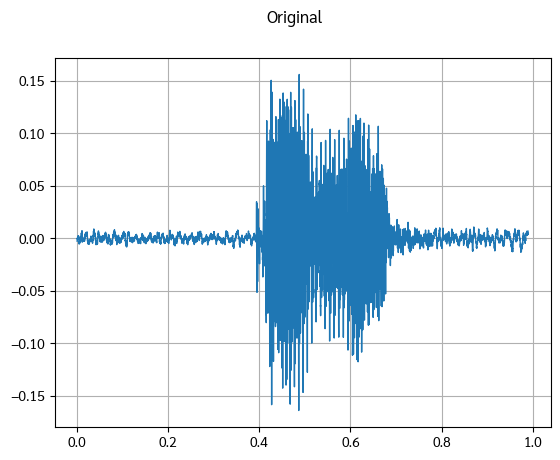

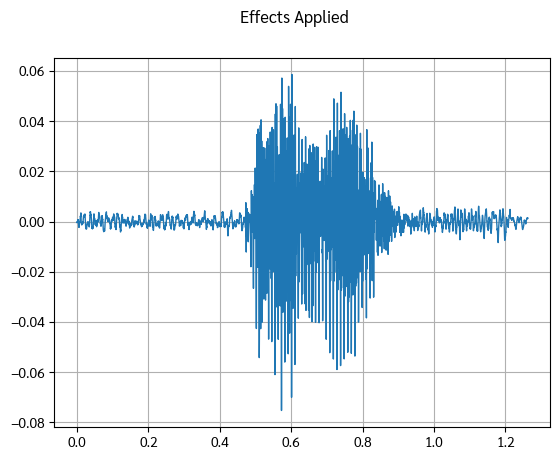

In [42]:
def rand_string():
    import secrets
    import string

    def generate_random_string(length):
        characters = string.digits + string.ascii_lowercase
        return ''.join(secrets.choice(characters) for _ in range(length))

    random_string = generate_random_string(11)
    return random_string


def save_audio(path,waveform2,sample_rate):
    random_string = rand_string()
    path = path+"/"+random_string+".wav"
    torchaudio.save(path, waveform2, sample_rate,channels_first=False)
    inspect_file(path)
    
def effect_filter(path,relative_path,toggle):
    waveform1, sample_rate = torchaudio.load(path, channels_first=False)
    
    effect = ",".join(
        [
            "lowpass=frequency=300:poles=1",  # single-pole lowpass filter
            "atempo=0.8",  # reduce the speed
            "aecho=in_gain=0.7:out_gain=0.9:delays=50:decays=0.3" # echo
        ],
    )

    def apply_effect(waveform, sample_rate, effect):
        effector = torchaudio.io.AudioEffector(effect=effect)
        return effector.apply(waveform, sample_rate)


    waveform2 = apply_effect(waveform1, sample_rate, effect)

    # print(waveform1.shape, sample_rate)
    # print(waveform2.shape, sample_rate)
    if toggle:
        plot_waveform(waveform1.T, sample_rate, title="Original")
        # Audio(waveform1.T, rate=sample_rate)

        plot_waveform(waveform2.T, sample_rate, title="Effects Applied")
        # Audio(waveform2.T, rate=sample_rate)

    save_audio(f"/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/{relative_path}",waveform2,sample_rate)

def run_files_in_path(path,toggle):
    for root, dirs, files in os.walk(path):
        for file in files:
            filename = os.path.join(root, file)
            relative_path = os.path.relpath(filename, path).split("/")[0].strip()
            if toggle:
                effect_filter(filename,relative_path,toggle)
                toggle = False
            else:
                effect_filter(filename,relative_path,toggle)

toggle = True
            
run_files_in_path("/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_mono",toggle)

## Audiomentations

In [60]:
from audiomentations import Compose, AddGaussianNoise, PitchShift, AddBackgroundNoise, PolarityInversion, TimeMask
import soundfile as sf
import librosa

def rand_string():
    import secrets
    import string

    def generate_random_string(length):
        characters = string.digits + string.ascii_lowercase
        return ''.join(secrets.choice(characters) for _ in range(length))

    random_string = generate_random_string(11)
    return random_string

def save_audio(path,waveform2,sample_rate):
    random_string = rand_string()
    path = path+"/"+random_string+".wav"
    sf.write(path,waveform2,sample_rate)

    # inspect_file(path)
    return waveform2

def Audiomentations(path,relative_path):
    augment = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.7),
        # PitchShift(min_semitones=-4, max_semitones=4, p=0.7),
        # AddBackgroundNoise(
        #     sounds_path=SAMPLE_NOISE,
        #     min_snr_in_db=15.0,
        #     max_snr_in_db=25.0,
        #     noise_transform=PolarityInversion(),
        #     p=0.7
        # ),
        # TimeMask(
        #     min_band_part=0.07,
        #     max_band_part=0.11,
        #     fade=True,
        #     p=0.7,
        # )
    ])

    signal, sample_rate = librosa.load(path)

    augmented_samples = augment(signal, sample_rate)

    save_audio(f"/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/{relative_path}",augmented_samples,sample_rate)

def run_files_in_path(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            filename = os.path.join(root, file)
            relative_path = os.path.relpath(filename, path).split("/")[0].strip()
            Audiomentations(filename,relative_path)
    print("DONE....")
    
            
run_files_in_path("/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds")


DONE....


# Import Data dataset

In [9]:
DATASET_PATH = './Data_sounds_aug'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  print('Data not found')

print("dir:",data_dir)

dir: Data_sounds_aug


In [10]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

print('Commands:', commands)

Commands: ['เกิด' 'โบ้' 'แมว' 'แกน' 'บูม' 'สิง' 'ปิด' 'เปิด' 'วิ่ง' 'ประตู']


In [11]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=16,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 2500 files belonging to 10 classes.
Using 2000 files for training.
Using 500 files for validation.

label names: ['บูม' 'ประตู' 'ปิด' 'วิ่ง' 'สิง' 'เกิด' 'เปิด' 'แกน' 'แมว' 'โบ้']


2024-03-15 09:23:14.237521: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-15 09:23:14.237548: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-15 09:23:14.237561: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-15 09:23:14.237620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 09:23:14.237636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
def squeeze(audio, labels):
  # audio = tf.squeeze(audio, axis=-1)
  audio = tf.reduce_sum(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


Creates a Dataset that includes only `1/num_shards` of this dataset. Shard is deterministic. The Dataset produced by A.shard(n, i) will contain all elements of A whose index mod n = i.

In [14]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [15]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(16, 16000)
(16,)


2024-03-15 09:23:20.672461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Plot a few audio waveforms:

In [16]:
label_names[[1,1,3,0]]

array(['ประตู', 'ประตู', 'วิ่ง', 'บูม'], dtype='<U5')

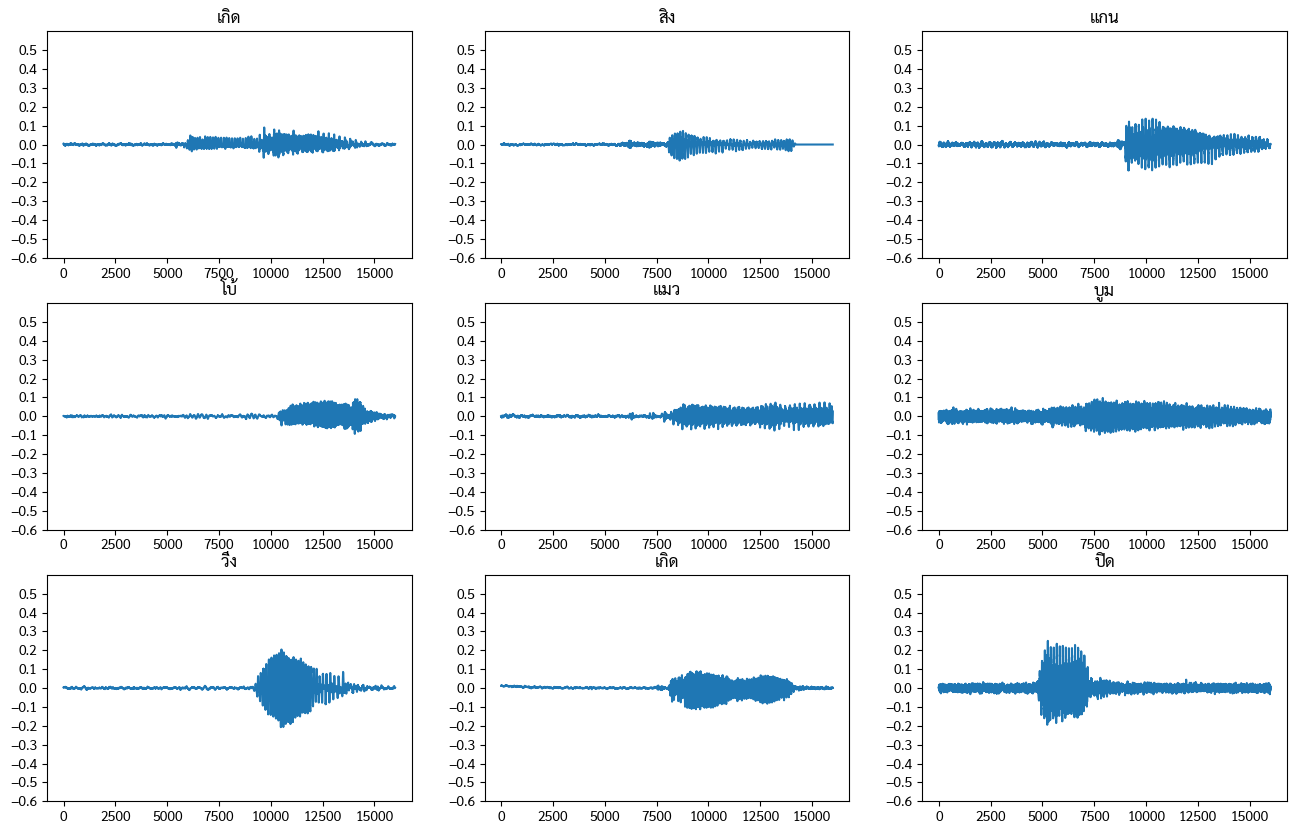

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-0.6, 0.6, 0.1))
  plt.ylim([-0.6, 0.6])

# Convert waveforms to spectrograms

In [18]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

Start exploring the data and play the original audio:

In [19]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: เกิด
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: สิง
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: แกน
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Function for displaying a spectrogram:

In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

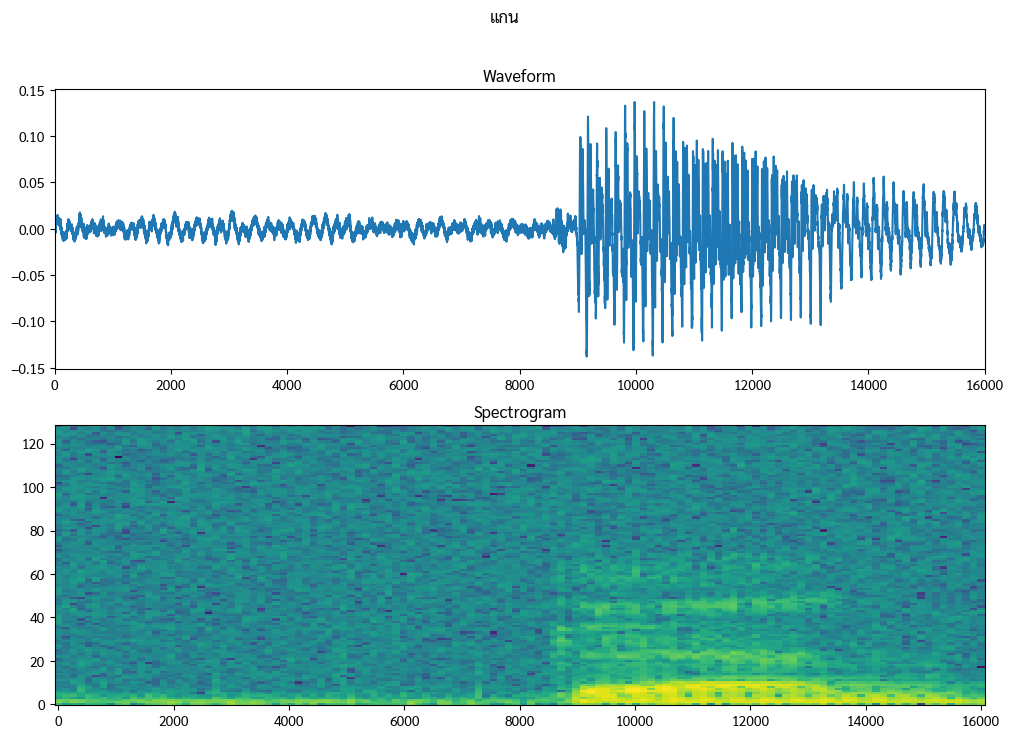

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Create spectrogram datasets from the audio datasets:

In [22]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [24]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

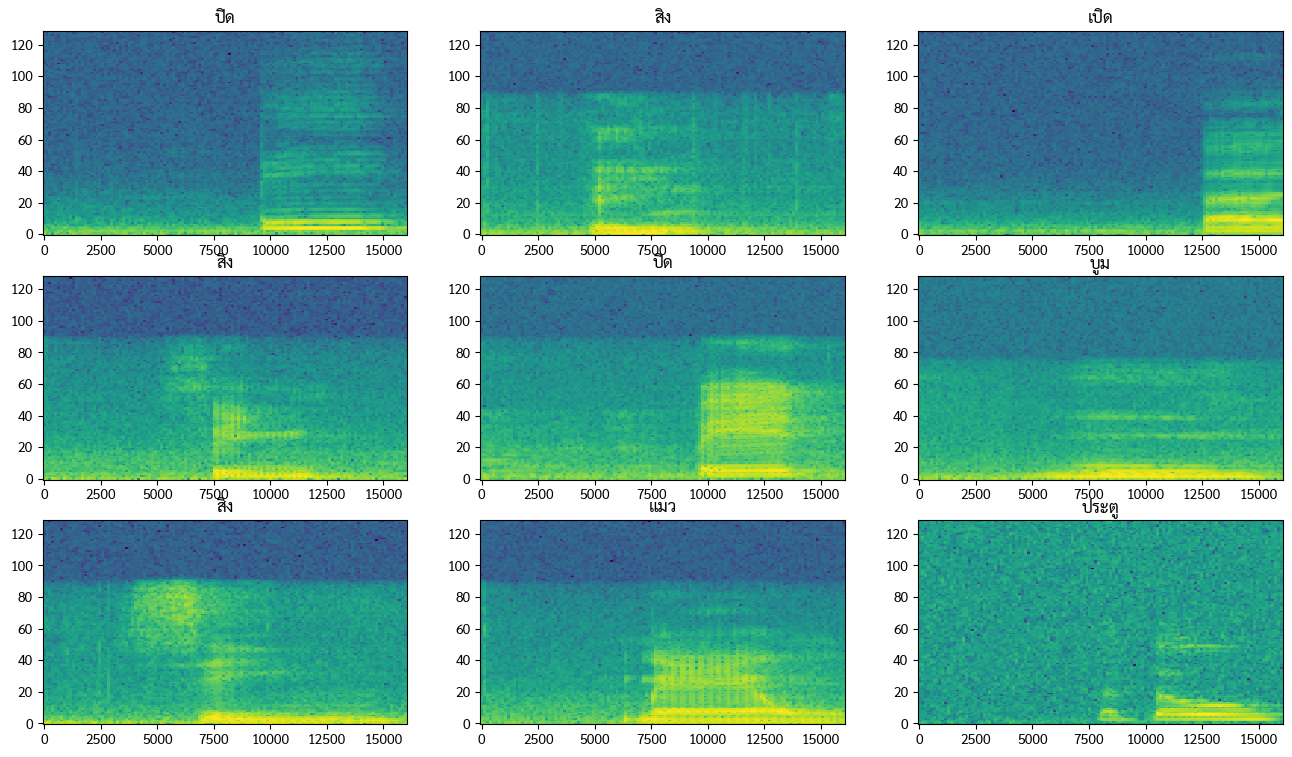

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build and train the model

In [38]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [39]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    # layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2024-03-15 09:59:53.280000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 124, 129, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 122, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,474,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,494,477 (116.33 MB)

 Trainable params: 30,494,474 (116.33 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model:

In [281]:
EPOCHS = 5
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.2488 - loss: 2.4301 - val_accuracy: 0.6352 - val_loss: 1.0277
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - accuracy: 0.6168 - loss: 1.1119 - val_accuracy: 0.7582 - val_loss: 0.7238
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.7939 - loss: 0.6308 - val_accuracy: 0.8484 - val_loss: 0.5154
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.8591 - loss: 0.4402 - val_accuracy: 0.8525 - val_loss: 0.4340
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.9058 - loss: 0.2874 - val_accuracy: 0.8689 - val_loss: 0.4192


Plot the training and validation loss curves:

Text(0, 0.5, 'Accuracy [%]')

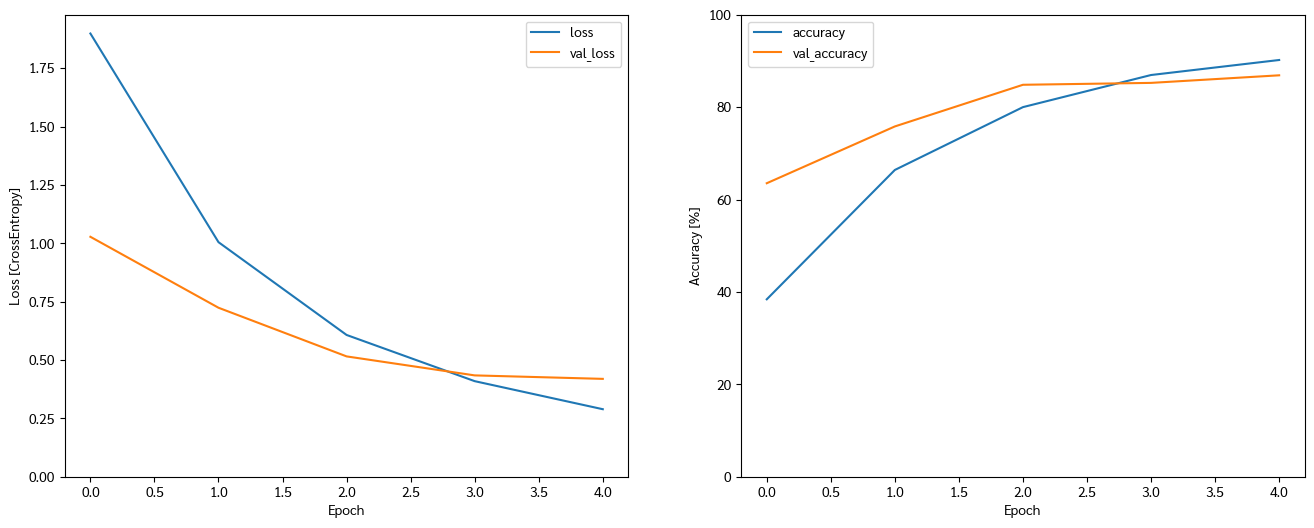

In [282]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Evaluate the model performance

Run the model on the test set:

In [283]:
model.evaluate(test_spectrogram_ds, return_dict=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8732 - loss: 0.3791


{'accuracy': 0.8828125, 'loss': 0.3583773672580719}

### Display a confusion matrix


In [284]:
y_pred = model.predict(test_spectrogram_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [285]:
y_pred = tf.argmax(y_pred, axis=1)

In [286]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2024-03-11 22:37:53.195277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


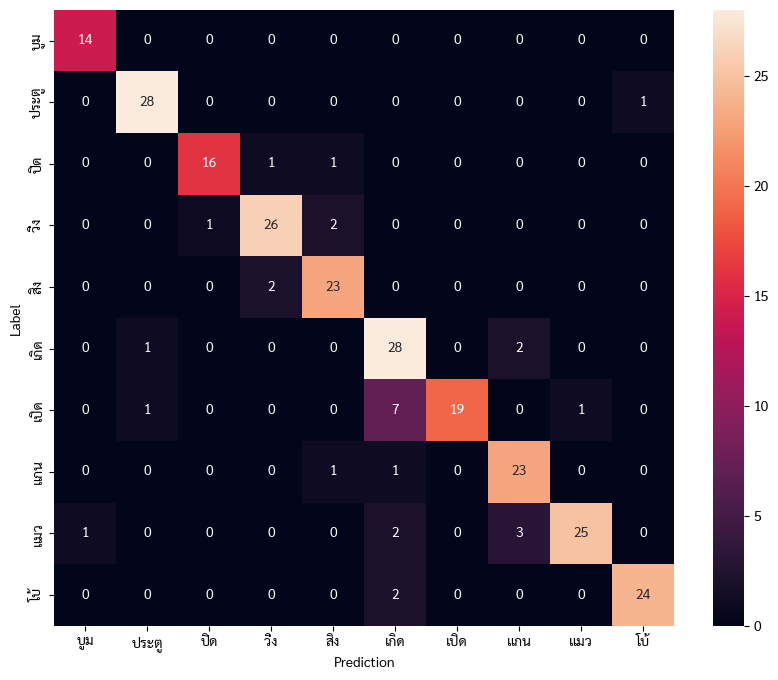

In [287]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Run inference on an audio file

tf.Tensor(
[ 4.149771    2.0833507  -6.451707   -1.6063002  -5.101559   -0.50015783
  0.11731938 -0.11047883 -6.0751534   2.3483415 ], shape=(10,), dtype=float32)


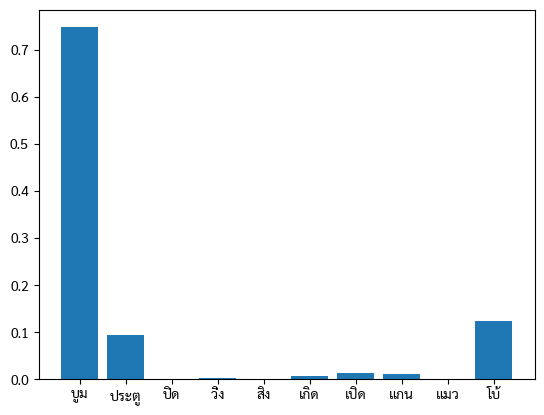

In [47]:
x = "/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_mono/บูม/122woxqmx4.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

# loaded_model = tf.keras.models.load_model("saved_model_1.keras")

prediction = model(x)
# prediction = loaded_model(x)

print(prediction[0])
x_labels = ['บูม', 'ประตู', 'ปิด', 'วิ่ง', 'สิง', 'เกิด', 'เปิด', 'แกน', 'แมว', 'โบ้']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
# plt.title('บูม')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Export the model with preprocessing

In [301]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [302]:
export = ExportModel(model)
export(tf.constant(str("/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_aug/ประตู/2jjw2rw8u0x.wav")))

{'predictions': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 0.1429805 ,  6.978152  , -2.5138063 ,  0.14957212, -1.9015882 ,
         -1.4733274 , -3.9425979 , -4.0410786 , -4.7228327 , -1.4177098 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'\xe0\xb8\x9b\xe0\xb8\xa3\xe0\xb8\xb0\xe0\xb8\x95\xe0\xb8\xb9'],
       dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [303]:
tf.saved_model.save(export, "saved_1")
imported = tf.saved_model.load("saved_1")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved_1/assets


INFO:tensorflow:Assets written to: saved_1/assets


{'predictions': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-5.9867687 , -3.5517704 , -5.977813  ,  0.74646926, -1.3181037 ,
          1.9687246 ,  1.6644785 ,  1.3053457 , -2.7291524 , -3.0496192 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'\xe0\xb9\x80\xe0\xb8\x81\xe0\xb8\xb4\xe0\xb8\x94'], dtype=object)>}

# Recording from mic and predict:

In [26]:
import pyaudio
import numpy as np

FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()



def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )
    
    print("start recording...")

    frames = []
    seconds = 2.5
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    print("recording stopped")

    stream.stop_stream()
    stream.close()
    
    return np.frombuffer(b''.join(frames), dtype=np.int16)


def terminate():
    p.terminate()

In [27]:
import numpy as np
import tensorflow as tf


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def preprocess_audiobuffer(waveform):
    """
    waveform: ndarray of size (16000, )
    
    output: Spectogram Tensor of size: (1, `height`, `width`, `channels`)
    """
    #  normalize from [-32768, 32767] to [-1, 1]
    waveform =  waveform / 32768

    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    print(waveform)
    spectogram = get_spectrogram(waveform)
    
    # add one dimension
    spectogram = tf.expand_dims(spectogram, 0)
    
    return spectogram

Define function matching command and trigger arduino servo:

In [34]:
from pyfirmata import Arduino, SERVO
import time

def servo_control():
  board = Arduino('/dev/cu.usbmodem1201')

  pin_9 = board.digital[9]
  pin_9.mode = SERVO

  pin_9.write(0)

  time.sleep(1)
  pin_9.write(90)

  time.sleep(2)
  pin_9.write(0)

# servo_control()

In [29]:
password = ["ประตู","ประตู","ประตู"]

def matching_pass(predict_password):
  for idx, x in enumerate(predict_password):
    if x != password[idx]:
      print("Password not correct")
      return
  print("Password correct")
  print("Door open...")
  servo_control()

Get input from mic:

start recording...
recording stopped
tf.Tensor(
[ 0.00088501 -0.003479   -0.05792236 ... -0.00949097 -0.00354004
 -0.00036621], shape=(38400,), dtype=float32)
Predicted label: ประตู


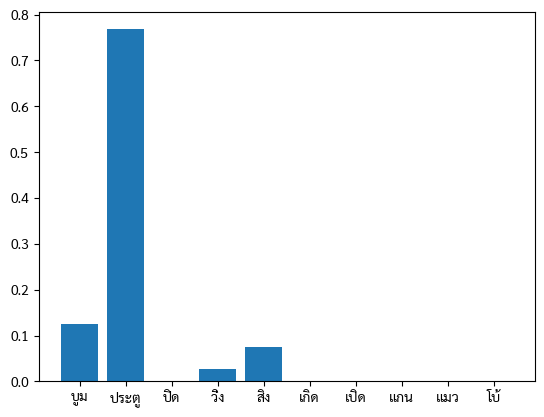

start recording...
recording stopped
tf.Tensor(
[ 0.00045776 -0.00180054 -0.02606201 ... -0.04495239 -0.04116821
 -0.02957153], shape=(38400,), dtype=float32)
Predicted label: ประตู


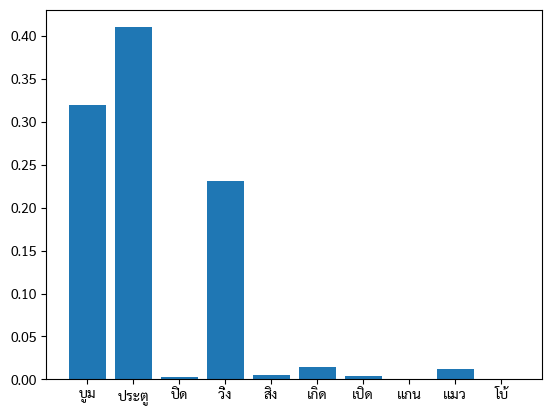

start recording...
recording stopped
tf.Tensor(
[ 0.00015259 -0.00085449 -0.01702881 ...  0.01681519  0.01269531
  0.01559448], shape=(38400,), dtype=float32)
Predicted label: แมว


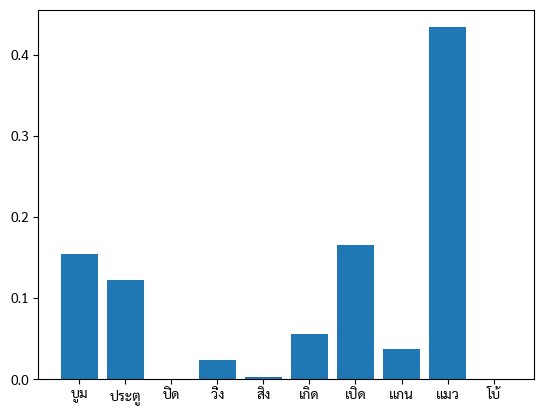

Password not correct


In [35]:
import numpy as np

from tensorflow.keras import models

import pyaudio
import numpy as np

FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

# !! Modify this in the correct order
commands = ['บูม', 'ประตู', 'ปิด', 'วิ่ง', 'สิง', 'เกิด', 'เปิด', 'แกน', 'แมว', 'โบ้']

loaded_model = tf.keras.models.load_model("saved_model_1.keras")

def predict_mic():
    audio = record_audio()
    spec = preprocess_audiobuffer(audio)
    prediction = loaded_model(spec)
    label_pred = np.argmax(prediction, axis=1)
    command = commands[label_pred[0]]
    print("Predicted label:", command)

    plt.bar(commands, tf.nn.softmax(prediction[0]))
    # plt.title('บูม')
    plt.show()
    return command

counter = 0
predict_password = []

while True:
    if counter >= 3:
        terminate()
        matching_pass(predict_password)
        break
    command = predict_mic()
    predict_password.append(command)
    counter += 1

# test

In [8]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.1.2-arm64-arm-64bit
Tensor Flow Version: 2.16.1

Python 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [328]:
new_model = model.save('saved_model_1.keras')

In [329]:
new_model = tf.keras.models.load_model('saved_model_1.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 124, 129, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 122, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 120, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 238080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    30,474,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,483,427 (348.98 MB)

 Trainable params: 30,494,474 (116.33 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 60,988,950 (232.65 MB)

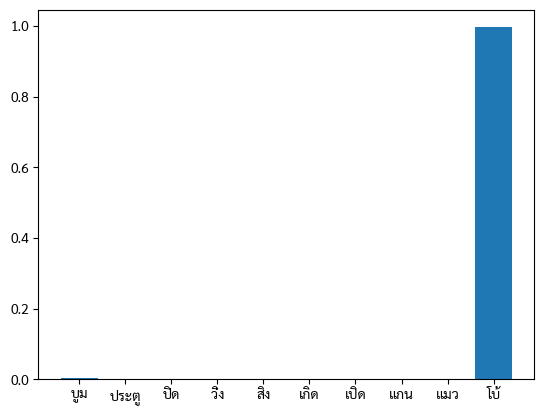

In [331]:
x = "/Users/boomctr/Documents/VisualCode/Project_ml/Data_sounds_mono/บูม/1l0y3t75sc.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = new_model(x)
x_labels = ['บูม', 'ประตู', 'ปิด', 'วิ่ง', 'สิง', 'เกิด', 'เปิด', 'แกน', 'แมว', 'โบ้']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
# plt.title('บูม')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [408]:
from pyfirmata import Arduino, SERVO
import time

board = Arduino('/dev/cu.usbmodem1101')

pin_9 = board.digital[9]
pin_9.mode = SERVO

pin_9.write(0)

time.sleep(1)
pin_9.write(90)

time.sleep(2)
pin_9.write(0)

# time.sleep(1)
# pin_9.write(90)